In [1]:
from PIL import Image
from transformers import AutoProcessor, AutoModel
import torch

In [10]:
from datasets import load_dataset

dataset = load_dataset("frgfm/imagenette",'160px')

Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

In [16]:
images = dataset['train']['image']

In [18]:
labels = dataset['train']['label']

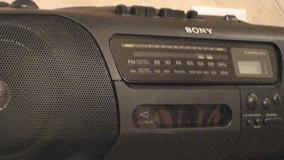

In [23]:
import PIL.Image
import IPython.display
image = images[0]
IPython.display.display(image)

In [35]:
all_labels = ["tench", "English springer", "cassette player", "chain saw", "church", "French horn", "garbage truck", "gas pump", "golf ball", "parachute"]

In [36]:
all_labels_dict = {all_labels[i]: i for i in range(len(all_labels))}

In [37]:
len(all_labels)

10

In [38]:
model = AutoModel.from_pretrained("google/siglip-base-patch16-224")
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")

In [39]:
def get_text_probs_test(X, y, size=-1):
  if size == -1:
    size = X.shape[0]
  probs = []
  names = []
  for i in range(size):
    inputs = processor(text=all_labels, images=X[i], padding="max_length", return_tensors="pt")
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs.append(torch.sigmoid(logits_per_image))
    names.append(y[i])
  return names, probs

In [42]:
names, probs = get_text_probs_test(images, labels , size=5)

In [41]:
import tensorflow as tf

In [46]:
def accuracy(names, probs, k=1):
  right = 0
  for name, p in zip(names, probs):
    _, top = p.clone().detach().topk(k, dim=-1)
    result = tf.reduce_any(tf.equal(top, names)).numpy()
    if result:
      right += 1
  return right / len(names)

In [47]:
accuracy(names, probs)

1.0

In [48]:
import matplotlib.pyplot as plt
import numpy as np

In [65]:
def show_img(result, names, true, img):
  plt.imshow(img, cmap=plt.cm.binary)
  color = 'g' if int(result) == true else 'r'
  plt.xlabel(f"{all_labels[int(result)]} ({all_labels[true]})", color=color)

In [62]:
def show_bar(p, true):
    plt.yticks([])
    plt.xticks(range(len(all_labels)))
    plot = plt.bar(range(len(all_labels)), p.tolist()[0])
    plot[true].set_color('g')

In [63]:
def show_all(names, probs, X, y):
    cols = 3
    rows = len(names) // cols if len(names) % cols == 0 else len(names) // cols + 1
    plt.figure(figsize=(2 * 2 * cols, 2 * rows))
    plt.figure(figsize=(2 * 2 * cols, 2 * rows))
    for i in range(len(names)):
      _, top = probs[i].clone().detach().topk(k=1, dim=-1)
      result = tf.reduce_any(tf.equal(top, names[i])).numpy()
      plt.subplot(rows, 2 * cols, 2 * i + 1)
      show_img(top.tolist()[0][0], names, y[i], X[i])
      plt.subplot(rows, 2 * cols, 2 * i + 2)
      show_bar(probs[i], y[i])
    plt.tight_layout()
    plt.show()

<Figure size 1200x400 with 0 Axes>

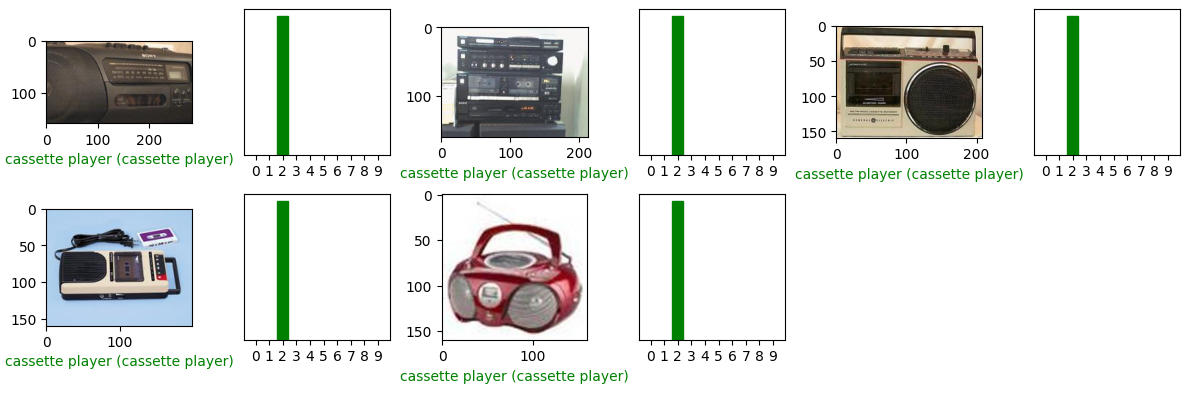

In [66]:
show_all(names, probs, images, labels)